In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# Sun normal stuff

These cells are to test creation of the sun normal. 

Important note: The elevation is not the same as the angle in the
spherecal cordinate system somehow. I guess in spherical coordinates it
is measured from the z axis to the vector...

In [2]:
elevation = np.deg2rad(90-60)
azimuth = np.deg2rad(180)

sun_normal = np.array([np.sin(elevation) * np.cos(azimuth), np.sin(elevation) * np.sin(azimuth), np.cos(elevation)])


(0.0, 1.0)

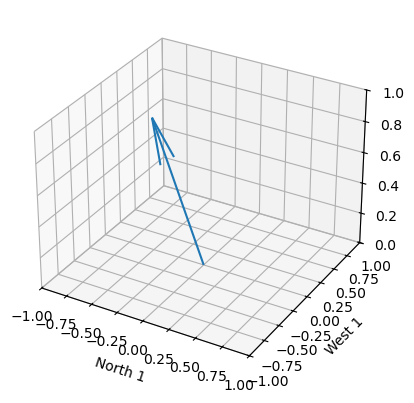

In [3]:
axis = plt.figure().add_subplot(projection='3d')
axis.quiver(0,0,0,sun_normal[0], sun_normal[1], sun_normal[2])

axis.set_xlim([-1,1])
axis.set_xlabel('North 1')
axis.set_ylim([-1,1])
axis.set_ylabel('West 1')
axis.set_zlim([0,1])

Now lets see if we can get emepheris data in here... We use pyephem for
this. 

In [4]:
from astropy.coordinates import EarthLocation, AltAz, get_sun
from astropy.time import Time
import astropy.units as u

In [5]:
essen_lat = 51.458069*u.deg
essen_lon = 7.014761*u.deg
essen_elevation = 116*u.m
essen = EarthLocation(lon=essen_lon, lat=essen_lat, height=essen_elevation)
essen_date = Time('2024-7-28 11:00:00')
essen_frame = AltAz(obstime=essen_date, location=essen)
sun = get_sun(essen_date)
sun_altaz = sun.transform_to(essen_frame)
print(f'Sun azimuth: {sun_altaz.az} Sun elevation: {sun_altaz.alt}')

Sun azimuth: 163.3670234474097 deg Sun elevation: 56.47771285753752 deg


# Animation

Let's see if we can animate a vector that points to the sun over time.
Or first let's just plot the azimuth and elevation.

In [6]:
time_start = Time('2024-9-22 00:00:00')
SAMPLES = 995
times = time_start + u.hour * np.linspace(0.,24., SAMPLES)

In [7]:
sun_data = get_sun(times)
essen_frame = AltAz(obstime=times, location=essen)
sun_data_altaz = sun_data.transform_to(essen_frame)

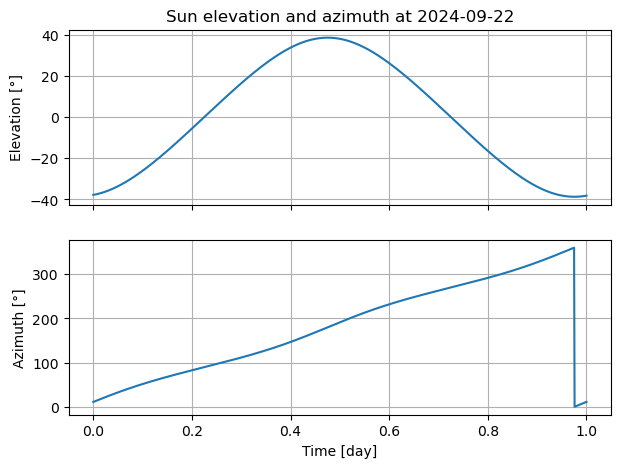

In [8]:
fig, (ax_alt, ax_az) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax_alt.plot((times.plot_date - times.plot_date[0]), sun_data_altaz.alt)
ax_alt.grid(True, which='both')
ax_alt.set_ylabel('Elevation [°]')
ax_alt.set_title(f'Sun elevation and azimuth at {time_start.to_datetime().date()}')
ax_az.plot((times.plot_date - times.plot_date[0]), sun_data_altaz.az)
ax_az.grid(True, which='both')
ax_az.set_xlabel('Time [day]')
ax_az.set_ylabel('Azimuth [°]')

fig.set_size_inches(7,5)

In [9]:
sun_alts = np.deg2rad(90 - np.array(sun_data_altaz.alt))
sun_azs = np.deg2rad(np.array(sun_data_altaz.az))
sun_normals = np.array([np.sin(sun_alts) * np.cos(sun_azs), np.sin(sun_alts) * np.sin(sun_azs), np.cos(sun_alts)])

In [10]:
np.any(sun_alts > np.pi/2)

np.True_

We are really close now. lets define a panel with a normal...

In [11]:
panel_azimuth = np.deg2rad(np.array([40,40,340,340,340,40,40,340,340,340,40,40,340,340,340]))
panel_tilt = np.deg2rad(np.array([20,30,45,0,60,20,30,45,0,60,20,30,45,0,60]))

panel_normal = np.array([np.sin(panel_tilt) * np.cos(panel_azimuth), np.sin(panel_tilt) * np.sin(panel_azimuth), np.cos(panel_tilt)])
cos_theta = (np.dot(panel_normal.T, sun_normals))
panel_normal.shape
sun_normals.shape

(3, 995)

In [12]:
cos_theta.shape


(15, 995)

In [13]:
cos_theta[:,sun_alts > np.pi/2] = 0 # sun is not up
cos_theta[cos_theta < 0] = 0 # sun is not in front of panel

In [14]:
cum_cos_theta = np.sum(cos_theta, axis=0)
cum_cos_theta.shape

(995,)

In [15]:
sun_normals[:,6]

array([ 0.76994382,  0.19102611, -0.60884771])

In [16]:
panel_normal

array([[ 0.26200263,  0.38302222,  0.66446302,  0.        ,  0.81379768,
         0.26200263,  0.38302222,  0.66446302,  0.        ,  0.81379768,
         0.26200263,  0.38302222,  0.66446302,  0.        ,  0.81379768],
       [ 0.21984631,  0.3213938 , -0.24184476, -0.        , -0.29619813,
         0.21984631,  0.3213938 , -0.24184476, -0.        , -0.29619813,
         0.21984631,  0.3213938 , -0.24184476, -0.        , -0.29619813],
       [ 0.93969262,  0.8660254 ,  0.70710678,  1.        ,  0.5       ,
         0.93969262,  0.8660254 ,  0.70710678,  1.        ,  0.5       ,
         0.93969262,  0.8660254 ,  0.70710678,  1.        ,  0.5       ]])

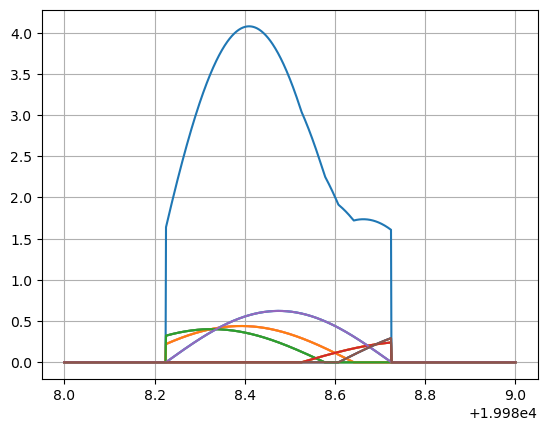

In [17]:
plt.plot(times.plot_date, cum_cos_theta)
plt.plot(times.plot_date, cos_theta.T)
plt.grid(True, which='both')

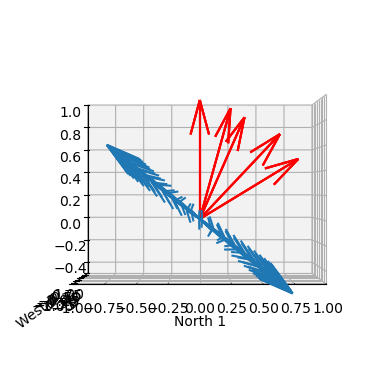

In [18]:
axis = plt.figure().add_subplot(projection='3d')
axis.quiver(0,0,0,sun_normals[0,::20], sun_normals[1,::20], sun_normals[2,::20])
axis.quiver(0,0,0,panel_normal[0,:], panel_normal[1,:], panel_normal[2,:], color='red')

axis.set_xlim([-1,1])
axis.set_xlabel('North 1')
axis.set_ylim([-1,1])
axis.set_ylabel('West 1')
axis.set_zlim([-.5,1])

axis.view_init(elev=0,azim=270,roll=0)

In [19]:
import pandas as pd

In [20]:
power_demand_1_file = r"..\dat\power_demand_characteristic_1.csv"
power_demand_2_file = r"..\dat\power_demand_characteristic_2.csv"
power_demand_1 = pd.read_csv(power_demand_1_file, header=1)
power_demand_1['X'] = power_demand_1['X']/24
power_demand_2 = pd.read_csv(power_demand_2_file, header=1)
power_demand_2['X'] = power_demand_2['X']/24

In [21]:
for dataFrame in [power_demand_1, power_demand_2]:
    dataFrame.loc[:,'X'] = dataFrame.loc[:,'X'].round(decimals=3)
    dataFrame.drop_duplicates(subset='X', ignore_index=True, inplace=True)

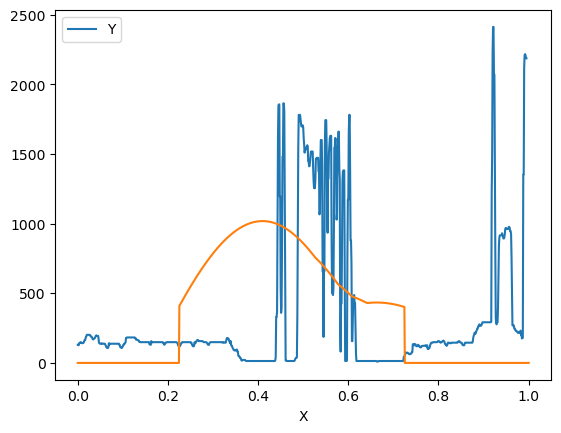

In [22]:
power_demand_1.plot(x='X', y='Y')
plt.plot(times.plot_date - times.plot_date[0], cum_cos_theta*250)

In [23]:
power_demand = pd.concat([power_demand_1.add_suffix('_1'), power_demand_2.add_suffix('_2')], axis=1)

In [24]:
power_demand.dropna(inplace=True)
power_demand['P_max'] = power_demand.loc[:,['Y_1', 'Y_2']].max(axis=1)
power_demand = power_demand.rename(columns={'X_1': 'Time_day'})
power_demand

,Time_day,Y_1,X_2,Y_2,P_max
0,0.000,130.319956,0.000,399.686543,399.686543
1,0.001,130.319956,0.001,399.686543,399.686543
2,0.002,126.558907,0.002,409.726588,409.726588
3,0.003,141.603102,0.003,429.806676,429.806676
4,0.004,141.603102,0.004,439.846720,439.846720
...,...,...,...,...,...
990,0.990,2119.914639,0.990,198.885659,2119.914639
991,0.991,2210.179804,0.991,198.885659,2210.179804
992,0.992,2217.701901,0.992,218.965748,2217.701901
993,0.993,2210.179804,0.993,239.045836,2210.179804


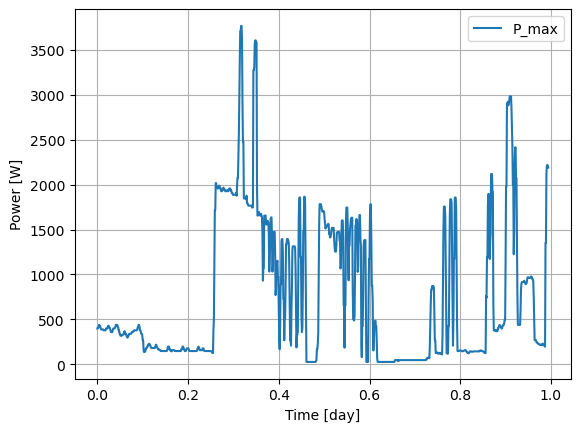

In [25]:
power_demand.plot(x='Time_day', y='P_max')
plt.xlabel('Time [day]')
plt.ylabel('Power [W]')
plt.grid(visible=True, which='both')

In [26]:
mean_average_percentage_error =  1/cum_cos_theta.shape[0] * np.sum(np.abs((power_demand.P_max - cum_cos_theta * 300)/power_demand.P_max))
mean_average_percentage_error

np.float64(3.0865712185311014)

In [27]:
power_demand.drop(columns=['Y_1', 'X_2', 'Y_2']).to_json('../dat/worst_case_power_demand_characteristic.json')

In [28]:
test_array = np.linspace(1,10,10)
test_array.reshape((2,5), order='F')

array([[ 1.,  3.,  5.,  7.,  9.],
       [ 2.,  4.,  6.,  8., 10.]])

In [29]:
azimuth_limits = np.array([[0], [np.deg2rad(360)]])
tilt_limits = np.array([[0], [np.deg2rad(90)]])
azimuth_limits

array([[0.        ],
       [6.28318531]])

In [30]:
azimuth_limit = np.repeat(azimuth_limits, repeats=4, axis=1)
tilt_limit = np.repeat(tilt_limits, repeats=4, axis=1)
np.hstack([azimuth_limit, tilt_limit])

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [6.28318531, 6.28318531, 6.28318531, 6.28318531, 1.57079633,
        1.57079633, 1.57079633, 1.57079633]])

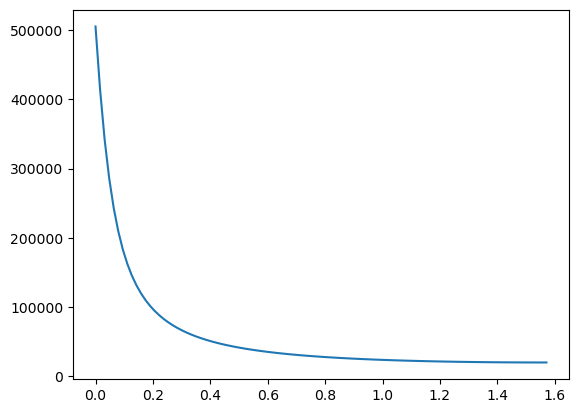

In [31]:
energy_consumed = np.array([0,4,-1,2,-5])
cost = np.zeros(energy_consumed.shape)
consuming_energy_mask = energy_consumed > 0
providing_energy_mask = energy_consumed < 0
cost[consuming_energy_mask] = energy_consumed[consuming_energy_mask] * 16e-2
cost[providing_energy_mask] = energy_consumed[providing_energy_mask] * 8e-2
np.sum(cost)
sun_altitude = np.deg2rad(np.linspace(0,90,100))
stratosphere_height = 20e3
radius_earth = 6371e3

side_a = radius_earth
side_c = (radius_earth + stratosphere_height)
angle_gamma = sun_altitude + np.pi/2

p_coefficient = -2*radius_earth*np.cos(angle_gamma)
q_coefficient = radius_earth**2 - (stratosphere_height + radius_earth)**2

distance = -p_coefficient/2 + np.sqrt((p_coefficient/2)**2 - (q_coefficient))
distance
plt.plot(sun_altitude, distance)

In [32]:
import pv_power_matching as PVPM

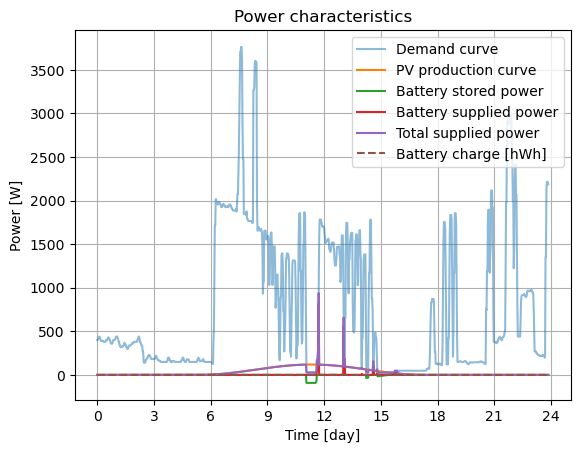

In [33]:
PVPM.plot_result_characteristics(np.array([3.1415, 0.2]), np.array([1]))

['Sun normals', 'Panel normals']

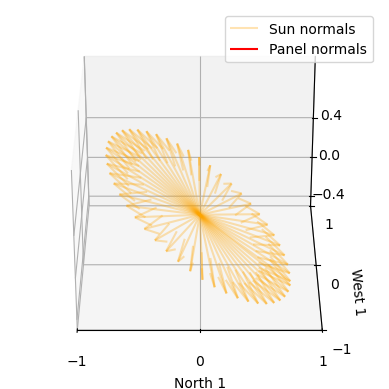

In [79]:
sun_normals,_,_ = PVPM.sun_position_for_time_and_location(PVPM.supply_times, PVPM.system_location)
panel_normals_empty = np.array([[],[],[]])
PVPM.plot_normals(sun_normals, panel_normals_empty)
axes = plt.gca()
axes.legend(labels=None)
axes.set_xticks(np.linspace(-1,1,3))
axes.set_yticks(np.linspace(-1,1,3))
axes.set_zticks(np.linspace(-0.4,0.4,3))

axes.get_legend_handles_labels()[1][:]

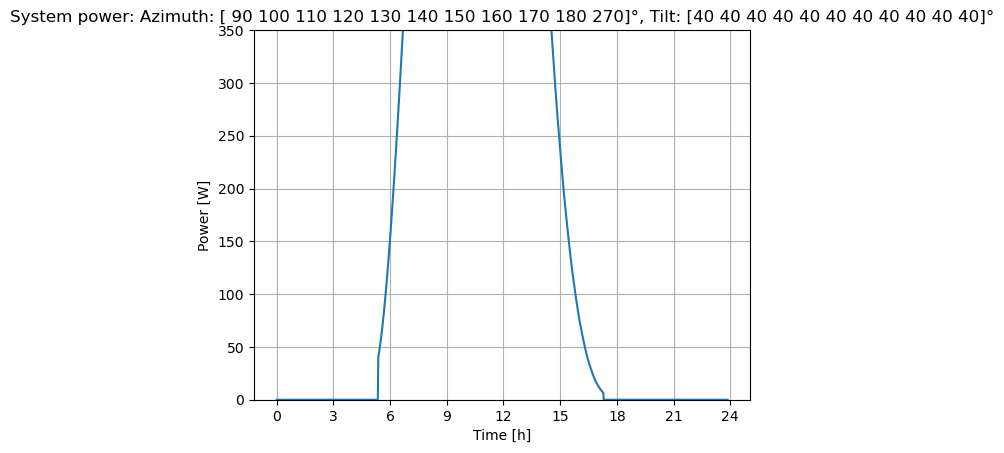

In [107]:
panel_orientation = np.array([[90,100,110,120,130,140,150,160,170,180,270], [40,40,40,40,40,40,40,40,40,40,40]])
power_supply_characteristic = PVPM.pv_system_power_production_characteristic(np.deg2rad(panel_orientation))
plt.plot(PVPM.demand_times*24, power_supply_characteristic.T)
plt.grid(visible=True)
plt.xticks(np.linspace(0,24,9))
plt.xlabel('Time [h]')
plt.ylabel('Power [W]')
plt.ylim([0, 350])
plt.title(f'System power: Azimuth: {panel_orientation[0,:]}°, Tilt: {panel_orientation[1,:]}°')
plt.show()

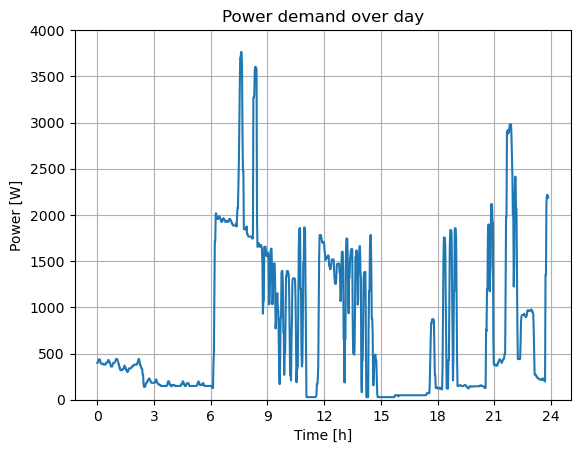

In [108]:
plt.plot(PVPM.demand_times*24, PVPM.power_demand_characteristic)
plt.grid(visible=True)
plt.xticks(np.linspace(0,24,9))
plt.xlabel('Time [h]')
plt.ylabel('Power [W]')
plt.ylim([0, 4000])
plt.title(f'Power demand over day')
plt.show()

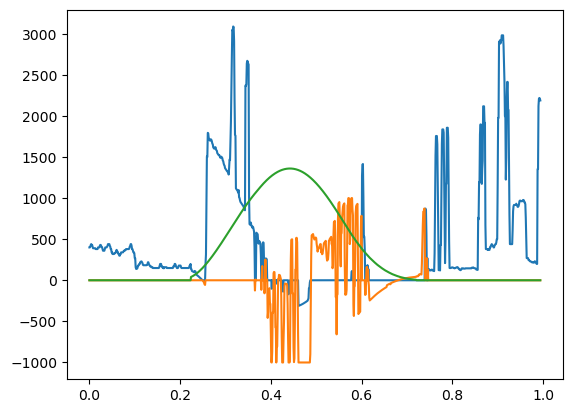

In [114]:
power_from_grid, battery_power, battery_charge = PVPM.simulate_home_as_grid_load(power_supply_characteristic)

plt.plot(PVPM.demand_times, power_from_grid)
plt.plot(PVPM.demand_times, battery_power)
plt.plot(PVPM.demand_times, power_supply_characteristic)

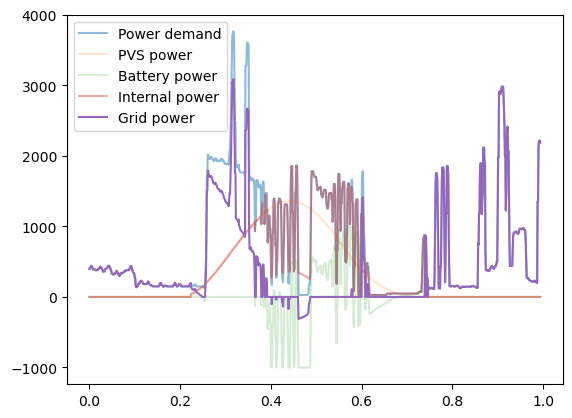

In [122]:

plt.plot(PVPM.demand_times, PVPM.power_demand_characteristic, alpha=0.5, label='Power demand')
plt.plot(PVPM.demand_times, power_supply_characteristic, alpha=0.2, label='PVS power')
plt.plot(PVPM.demand_times, battery_power, alpha=0.2, label='Battery power')
plt.plot(PVPM.demand_times, power_supply_characteristic + battery_power, alpha=0.4, label='Internal power')
plt.plot(PVPM.demand_times, PVPM.power_demand_characteristic - (power_supply_characteristic + battery_power), label='Grid power')
plt.legend()